Python Sentiment Analsyis for NBA as to if they will reach the hall of fame.

In [282]:
#import packages for analysis
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split

In [283]:
#import the inital player data with additional information
dsPlayers = pd.read_csv('Player Career Info.csv')
endOfSeason = pd.read_csv('End of Season Teams.csv')
allStarSelections = pd.read_csv('All-Star Selections.csv')
nbaCleanData = pd.read_csv('NBA_players_clean.csv')
awardShares = pd.read_csv('Player Award Shares.csv')

Okay, so we have all the information that we need, and now we can combine it all together to then make some machine learning predictions.

In [284]:
# We are starting with dsPlayers, our data set that we will work with.

#got rid of birth year as it is filled with NaN's and is irrelevant to work with.
dsPlayers.drop(columns=['birth_year'], inplace=True)

#lets restrict it to 2020 as it is unlikely these players will be in HOF in the
#first place
dsPlayers=dsPlayers[dsPlayers['first_seas']<2020]

Let's also make it possible to work with the HOF data so that it is useable with 1's and 0's instead of true and false.

In [285]:
i = 0

#here we are converting all of our true and false values
for player in dsPlayers['player']:
  if dsPlayers.at[i, 'hof'] == True:
    dsPlayers.at[i, 'hof'] = 1
  elif dsPlayers.at[i, 'hof'] == False:
    dsPlayers.at[i, 'hof'] = 0
  else:
    print("error")
  i += 1



Now let's add some collated data, which gives us better prediction models, but first let's check for any null values in the entire dataset, and then we will fix those.

In [286]:
dsPlayers.isnull().sum()


player_id      0
player         0
hof            0
num_seasons    0
first_seas     0
last_seas      0
dtype: int64

Ok, as we have no null values in this case, we can move on and add some additional values which should better help predict our hall of famers. We should add individual data for all players, we will start with the essential data to do with player performance, using our NBA clean player data. However, there are some issues with the data as asterix's mean that the name's can't always be filtered properly, so we will fix that.

In [287]:
i = 0
#here we iterate through all of the players, if we find one with
#an asterix at the end of the name, we know it belongs to a HOF player,
#so we remove it, and then we add 1 to the hof column so we have a record of this
for name in nbaCleanData['Player']:
  if name.endswith('*'):
    nbaCleanData.at[i, 'Player'] = name[:-1]


  i += 1



Ok, so now that is fixed, let's make a list of all the data that we want to add. With all of the columns of data from the other data set.

In [288]:
columnsToAdd = ['Height','Wt','G','PTS','TRB','AST','FG%','FT%','eFG%','PER','WS']
columnsToAdd2 = ['Championships','Finals MVP', 'Scoring Champ', 'AST Champ', 'TRB Champ']
columnsToAdd3 = ['STL Champ','BLK Champ','AS MVP', 'CF MVP', 'NBA 75 Team', 'ABA All-Time Team']
columnsToAdd4 = ['eFG%','PER']

I will now work with this data to add it to the player data that we already have.

In [289]:
#first lets collate all of the columns

all_columns = [columnsToAdd,columnsToAdd2,columnsToAdd3,columnsToAdd4]

#let us create a dictionary of player names to store to check against later
#(reduces complexity in this case)
player_data_map = {row['Player']: row for idx, row in nbaCleanData.iterrows()}

In [290]:
#lets now create all of the new columns which we will use and collate.

for columns in all_columns:
  for columns in columns:
    dsPlayers[columns] = 0

dsPlayers

,player_id,player,hof,num_seasons,first_seas,last_seas,Height,Wt,G,PTS,...,Finals MVP,Scoring Champ,AST Champ,TRB Champ,STL Champ,BLK Champ,AS MVP,CF MVP,NBA 75 Team,ABA All-Time Team
0,1,Al Brightman,0,1,1947,1947,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Al Lujack,0,1,1947,1947,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Al Negratti,0,1,1947,1947,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Angelo Musi,0,3,1947,1949,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Ariel Maughan,0,5,1947,1951,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,4682,Wendell Carter Jr.,0,6,2019,2024,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4682,4683,Yante Maten,0,1,2019,2019,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4683,4684,Yuta Watanabe,0,6,2019,2024,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4684,4685,Zach Lofton,0,1,2019,2019,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's go about adding all of our data here so we can later analysis it.

In [291]:
#iterate over all the rows to get data
i = 0
for player_name in dsPlayers['player']:
    if player_name in player_data_map:
        for column in all_columns:
          for columns in column:
            #for all columns lets collate the data together
            dsPlayers.at[i, columns] = player_data_map[player_name][columns]

    i += 1


In [292]:
#some NaN Values snuck in so lets drop these
dsPlayers.dropna(inplace=True)
dsPlayers


,player_id,player,hof,num_seasons,first_seas,last_seas,Height,Wt,G,PTS,...,Finals MVP,Scoring Champ,AST Champ,TRB Champ,STL Champ,BLK Champ,AS MVP,CF MVP,NBA 75 Team,ABA All-Time Team
0,1,Al Brightman,0,1,1947,1947,6.166667,195.0,58,9.8,...,0,0,0,0,0,0,0,0,0,0
1,2,Al Lujack,0,1,1947,1947,6.250000,220.0,5,0.8,...,0,0,0,0,0,0,0,0,0,0
2,3,Al Negratti,0,1,1947,1947,6.250000,200.0,11,2.8,...,0,0,0,0,0,0,0,0,0,0
3,4,Angelo Musi,0,3,1947,1949,5.750000,145.0,161,8.4,...,0,0,0,0,0,0,0,0,0,0
4,5,Ariel Maughan,0,5,1947,1951,6.333333,190.0,259,7.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,4682,Wendell Carter Jr.,0,6,2019,2024,6.833333,270.0,203,12.2,...,0,0,0,0,0,0,0,0,0,0
4682,4683,Yante Maten,0,1,2019,2019,6.666667,240.0,2,1.0,...,0,0,0,0,0,0,0,0,0,0
4683,4684,Yuta Watanabe,0,6,2019,2024,6.750000,215.0,121,3.8,...,0,0,0,0,0,0,0,0,0,0
4684,4685,Zach Lofton,0,1,2019,2019,6.333333,180.0,1,0.0,...,0,0,0,0,0,0,0,0,0,0


Ok, So finally let's add some last bits of data so we can then begin the analysis stage of the data with machine learning.

In [293]:
#we want to learn if players have been all-nba (1st, 2nd or 3rd), all- defense(1st or 2nd),
#all rookie (1st or 2nd), all star appearances, mvp's, dpoy, nba roy,
#mip, smoy, aba mvp, aba roy

#lets start with our end of season data set, and work from that.

#creating an index for the players in our original data set
player_name_data_map = {}
i = 0
for player_name in dsPlayers['player']:
    player_name_data_map[player_name] = i
    i+=1



In [294]:
#adding the new columns for the data.

columnsv2 = ['all-nba1','all-nba2','all-nba3','all-def1','all-def2','all-rook1','all-rook2']

for columns in columnsv2:
  dsPlayers[columns] = 0


In [295]:
for player in endOfSeason[endOfSeason['type'] == 'All-Rookie']['player']:
  if player in player_name_data_map:


    player_endOfSeason = endOfSeason[endOfSeason['player'] == player]


    if any(player_endOfSeason['number_tm'] == '1st'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-rook1'] += 1

    if any(player_endOfSeason['number_tm'] == '2nd'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-rook2'] += 1



So above we have added the player data for rookies players, and we can continue this for the rest of the categories.

In [296]:
#add the all defense players

for player in endOfSeason[endOfSeason['type'] == 'All-Defense']['player']:
  if player in player_name_data_map:


    player_endOfSeason = endOfSeason[endOfSeason['player'] == player]


    if any(player_endOfSeason['number_tm'] == '1st'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-def1'] += 1

    if any(player_endOfSeason['number_tm'] == '2nd'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-def2'] += 1


In [297]:
#add the all all-nba players

for player in endOfSeason[endOfSeason['type'] == 'All-NBA']['player']:
  if player in player_name_data_map:


    player_endOfSeason = endOfSeason[endOfSeason['player'] == player]


    if any(player_endOfSeason['number_tm'] == '1st'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-nba1'] += 1

    if any(player_endOfSeason['number_tm'] == '2nd'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-nba2'] += 1

    if any(player_endOfSeason['number_tm'] == '3rd'):
        dsPlayers.loc[dsPlayers['player'] == player, 'all-nba3']+= 1



Ok, so now we have added this data, let us add the final data of the award winners throughout the NBA season.

In [298]:
#adding the new columns for the data for the awards section.

columnsv3 = ['dpoy','mip','nba-mvp','nba-roy','smoy']

for columns in columnsv3:
  dsPlayers[columns] = 0


In [299]:
#add dpoy

for player in awardShares[awardShares['award'] == 'dpoy']['player']:
  if player in player_name_data_map:

    player_award =  awardShares[awardShares['player'] == player]


    if any(player_award['winner'] == True):
        dsPlayers.loc[dsPlayers['player'] == player, 'dpoy'] += 1


In [300]:
#add mip

for player in awardShares[awardShares['award'] == 'mip']['player']:
  if player in player_name_data_map:

    player_award =  awardShares[awardShares['player'] == player]


    if any(player_award['winner'] == True):
        dsPlayers.loc[dsPlayers['player'] == player, 'mip'] += 1

In [301]:
#add nba mvp

for player in awardShares[awardShares['award'] == 'nba mvp']['player']:
  if player in player_name_data_map:

    player_award =  awardShares[awardShares['player'] == player]


    if any(player_award['winner'] == True):
        dsPlayers.loc[dsPlayers['player'] == player, 'nba-mvp'] += 1



In [302]:
#add nba roy

for player in awardShares[awardShares['award'] == 'nba roy']['player']:
  if player in player_name_data_map:

    player_award =  awardShares[awardShares['player'] == player]


    if any(player_award['winner'] == True):
        dsPlayers.loc[dsPlayers['player'] == player, 'nba-roy'] += 1



In [303]:
#add nba smoy

for player in awardShares[awardShares['award'] == 'smoy']['player']:
  if player in player_name_data_map:

    player_award =  awardShares[awardShares['player'] == player]


    if any(player_award['winner'] == True):
        dsPlayers.loc[dsPlayers['player'] == player, 'smoy'] += 1


Okay, so now all our data is collated, and we are ready to run a machine learning program onto it. We will use the sklearn toolkit with its machine learning properties. However, we will first do some graphical analysis on the data we have already collected.

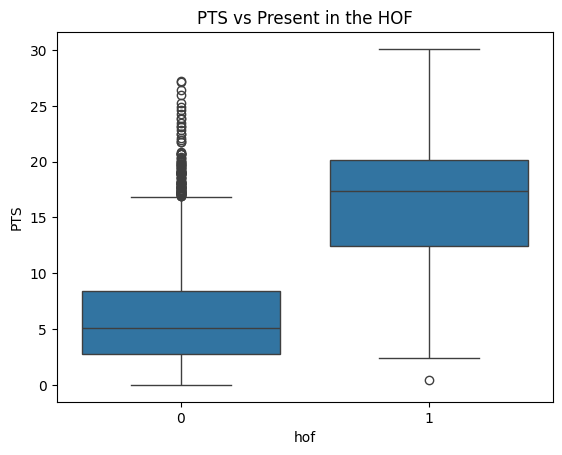

In [304]:
fig, ax = plt.subplots()
sns.boxplot(x='hof',y='PTS',data=dsPlayers)
plt.title("PTS vs Present in the HOF")
plt.show()

Clearly, by looking at this plotting of data, we can see there is a clear relation between the number of points and a player appearing in the hall of fame. We can do a few more for aother pieces of data.

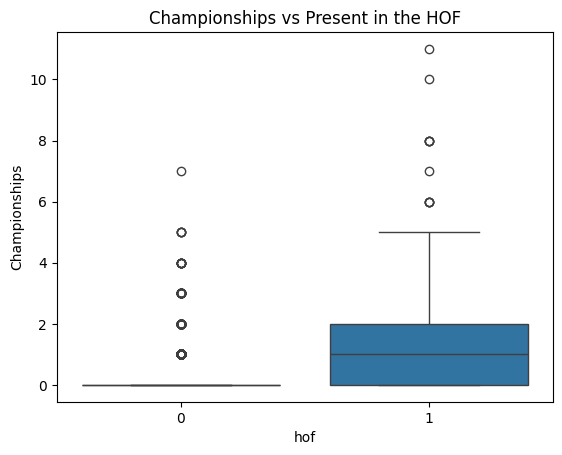

In [305]:
fig, ax = plt.subplots()
sns.boxplot(x='hof',y='Championships',data=dsPlayers)
plt.title("Championships vs Present in the HOF")
plt.show()

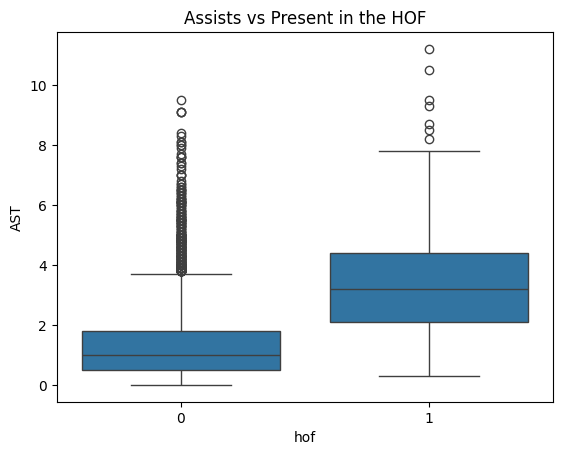

In [306]:
fig, ax = plt.subplots()
sns.boxplot(x='hof',y='AST',data=dsPlayers)
plt.title("Assists vs Present in the HOF")
plt.show()

Interestingly, here we see that there is no relation between height and being placed in the HOF, as this does not seem to be the limiting factor for whether a player makes it, and seems to be fairly consistent with the height statistics for the league as a whole.

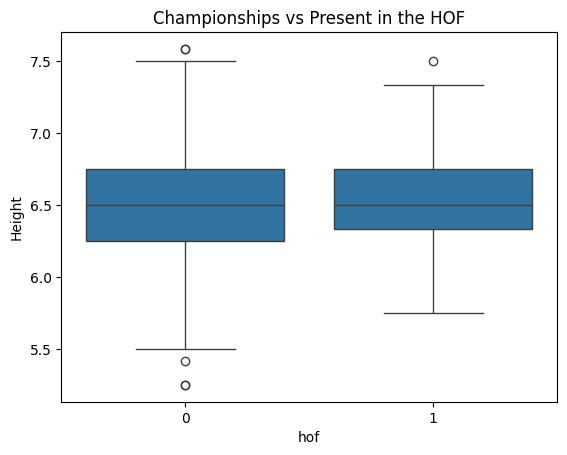

In [307]:
fig, ax = plt.subplots()
sns.boxplot(x='hof',y='Height',data=dsPlayers)
plt.title("Championships vs Present in the HOF")
plt.show()

We can also here do an analysis in terms of a scatter plot of the total amount of games played vs the amount of points scored for the players and see how the hall of fame players compare to the rest of the league.

In [308]:
fig = px.scatter(
    dsPlayers[dsPlayers['num_seasons'] > 4], x="PTS", y="G", color='hof',
    hover_data=['player']
)


fig.update_layout(title='Scatter Plot of PTS vs G for Players with more than 4 seasons')


fig.show()


So clearly we can see that there is a trend for the HOF players having more point as well as more games played, with them being much more likely to appear in the top right of the diagram. Meaning our machine learning algorithm should hopefully be quite accurate, let us do it for one more data set.

In [309]:
fig = px.scatter(
    dsPlayers[dsPlayers['num_seasons'] > 4], x="AST", y="TRB", color='hof',
    hover_data=['player']
)


fig.update_layout(title='Scatter Plot of AST vs TRB for Players with more than 4 seasons')


fig.show()

Looking at this data set, we can clearly see that HOFers often will have higher total rebound percentage, and we can also see they are more likely to have higher numbers of assists, which further strengthens our idea that we can use this to differentiate HOF from non HOFers.

##MACHINE LEARNING

Ok so now that all of our data collection is out of the way, we can now move on to the machine learning aspect of our analysis. We will use the SK Learn module with a random forest classifier as that is quite often a good model to use for this type of data sets. We will split the model up into two parts, our test set as well as our training set, where we will train our machine learn model on the train set and then test it on the test set so that we ensure it is not memorising data.

In [310]:
#first let us drop some columns we will not use.

#make a copy to do this analysis
#dropping some columns which should be irrelvant here
x = dsPlayers.drop(columns=['hof','player','player_id'])
y = dsPlayers['hof']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


Ok, so now our code is ready to preform the analysis and has been split up accordingly. Let's do this.

In [311]:
#let us create and initialise the random forest model
rf_nba_model = RandomForestClassifier(random_state=5)
#here we train our model
rf_nba_model.fit(x_train, y_train)

#we will make predicitions based on our x test data
y_pred = rf_nba_model.predict(x_test)

#we will then test the accuracy of the model here
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(100 * accuracy.round(2)) + '%')

Accuracy: 99.0%


Awesome! Our machine learning process has worked here in this case, with it having a very high accuracy score for predicting in our random test set who will make it to the NBA HOF.

We can complete some extra tests just to see where the model has gone wrong, and potentially learn something from this.

In [312]:
#let us add the predicted data back to our original data set

# Make predictions for both training and testing sets
y_pred_train = rf_nba_model.predict(x_train)
y_pred_test = rf_nba_model.predict(x_test)

# Concatenate the predicted values vertically
y_pred_combined = pd.concat([pd.Series(y_pred_train), pd.Series(y_pred_test)], axis=0)

# Reset index to match original dataset
y_pred_combined.reset_index(drop=True, inplace=True)

# Add predicted values to the original dataset
dsPlayers['predicted_hof'] = y_pred_combined

In [313]:
sum = 0
for index, row in dsPlayers.iterrows():
    if row['hof'] != row['predicted_hof']:

        sum +=1
print("Incorrectly assigned: " + str(sum))

Incorrectly assigned: 316


Therefore we can see that we have 316/5200 incorrect in this case, which means the approxiamtely 94% of our data set has correctly been matched which is a great reesult for our machine learning algorithm.

This is espcially good for this mode considering how it can be quite difficult to predict who will be inducted into the hall of fame, as it is not always purely on statistics, but can be also due to a players popularity and their effect off of the court, but we have only used on court data for this model prediction. Our model seemed to benefit more attacking players, as they were more likely to be inducted, as can be seen with Dennis Rodman below being in the hall of fame, despite our mode predicted he would not be. This is due to the fact that many of the players in the all def team as he was did not make it to the HOF so he was left off in this case, as well as his point scoring being quite low. So overall there will always be some players in the Hall of Fame who are quite hard to predict as they do not follow the pattern that others do in entering it, but we are still able to find the large majority to a high degree of accuracy.

In [315]:
dsPlayers[dsPlayers['player'] == 'Dennis Rodman']

,player_id,player,hof,num_seasons,first_seas,last_seas,Height,Wt,G,PTS,...,all-def1,all-def2,all-rook1,all-rook2,dpoy,mip,nba-mvp,nba-roy,smoy,predicted_hof
2300,2301,Dennis Rodman,1,14,1987,2000,6.583333,210.0,911,7.3,...,8,8,0,0,10,1,4,0,2,0


Ultimaly we have made quite a succsesful model which is able to predict HOF players in the NBA to quite a high accuracy. The techniques for machine learning here can be applied to many different use cases to predict outcomes with large data packages and get quite accurate results.